In [12]:
import carball
import gzip
from carball.json_parser.game import Game
from carball.analysis.analysis_manager import AnalysisManager
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.animation as animation
from matplotlib import rc
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
rc('animation', html='html5')
sns.set_context('talk')

In [ ]:
player_cols = ['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z',
       'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'rot_x', 'rot_y', 'rot_z','boost']
all_cols = []

import os
replays = []
for root, dirs, files in os.walk(r"C:\Users\blake\Documents\rlcsseason9"):
    for file in files:
        if file.endswith(".replay"):
            replays.append(os.path.join(root, file))
for x in range(1,7):
    for y in player_cols:
        all_cols.append(y+'_p{}'.format(x))
        
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def get_shots(replay):
    _json = carball.decompile_replay(replay)
    game = Game()
    game.initialize(loaded_json=_json)
    analysis_manager = AnalysisManager(game)
    analysis_manager.create_analysis()
    game_info = get_players(game)
    proto_object = analysis_manager.get_protobuf_data()
    player_cols = ['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z',
           'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'rot_x', 'rot_y', 'rot_z','boost']
    ball_cols = ['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z',
           'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'rot_x', 'rot_y', 'rot_z','frames','is_goal']

    pdict = {
        x.online_id : x.name
        for x in game.players
    }
    df = analysis_manager.get_data_frame()
    players = [x.name for x in game.players]
    shot_frames = []
    orangeshots = []
    goal_frames = []
    orangegoals = []
    shooterid = []
    js = analysis_manager.get_json_data()
    for x in js['gameStats']['hits']:
        pid = x['playerId']['id']
        is_orange = game_info[game_info['id'] == pid].is_orange.values[0]
        if 'shot' in x.keys() and x['frameNumber'] != df.index[-1]:
            shooterid.append(pid)
            if is_orange:
                orangeshots.append(x['frameNumber'])
            else:
                shot_frames.append(x['frameNumber'])
        
        if 'goal' in x.keys():
            if is_orange:
                orangegoals.append(x['frameNumber'])
            else:
                goal_frames.append(x['frameNumber'])
    #filter out goals that werent shot
    goal_frames = intersection(shot_frames, goal_frames)
    orangegoals = intersection(orangegoals, orangeshots)
    
    df = df.reset_index().rename(columns={'index':'frames'})
    flat = get_flat_df(players, df)
    df = df['ball']
    df = df.reset_index().rename(columns={'index':'frames'})
    
    cols = ['pos_x', 'pos_y',  'vel_x', 'vel_y', 'ang_vel_x',
           'ang_vel_y']
    try:
        df_orange = df[df.frames.isin(orangeshots)]
        pl_orange = flat[flat.frames.isin(orangeshots)]
        
        df_orange[cols] = df_orange[cols].apply(lambda x : -x)
        pl_orange[cols] = pl_orange[cols].apply(lambda x : -x)
        df_orange.loc[df_orange.frames.isin(orangegoals), 'is_goal'] = 1
    except:
        df_orange = pd.DataFrame()
    df.loc[df.frames.isin(goal_frames), 'is_goal'] = 1
    df = df[df.frames.isin(shot_frames)]
    pl = flat[flat.frames.isin(shot_frames)]
    df = df.append(df_orange)
    df = df.sort_values('frames')
    
    df['shooter_id'] = [pdict[x] for x in shooterid]  
    test = pd.DataFrame()
    for x,y in df.iterrows():
        shooter = y['shooter_id']
        print("SHOOTER:", shooter)
        is_orange = game_info.loc[game_info.name == shooter, 'is_orange'].values[0]
        orange = game_info.loc[game_info.is_orange == True].name.values
    
        if is_orange == True:
            temp_shooter = flat.loc[(flat.frames == y['frames']) & (flat.name == shooter), player_cols]
            temp_orange = flat.loc[(flat.frames == y['frames']) & (flat.name != shooter) & (flat.name.isin(orange)), player_cols]
            temp_blue = flat.loc[(flat.frames == y['frames']) & (~flat.name.isin(orange)), player_cols]
            for dataframe in [temp_shooter, temp_orange, temp_blue]:
                dataframe[cols] = dataframe[cols].apply(lambda x: -x)
            temp = temp_shooter.values.flatten().tolist() + temp_orange.values.flatten().tolist() + temp_blue.values.flatten().tolist()
        else:      
            temp_shooter = flat.loc[(flat.frames == y['frames']) & (flat.name == shooter), player_cols]
            temp_blue = flat.loc[(flat.frames == y['frames']) & (flat.name != shooter) & (~flat.name.isin(orange)), player_cols]
            temp_orange = flat.loc[(flat.frames == y['frames']) & (flat.name.isin(orange)), player_cols]
            temp = temp_shooter.values.flatten().tolist() + temp_blue.values.flatten().tolist() + temp_orange.values.flatten().tolist()
        temp = pd.DataFrame(temp).T
        temp['frames'] = y['frames']
        temp = temp.merge(df[ball_cols],on='frames')
        test = test.append(temp)
    test['id'] = proto_object.game_metadata.match_guid
    test['replay_name'] = replay
    test['date'] = game.datetime
    test.columns = all_cols + test.columns[78:].tolist()
    return test

shots_df = pd.DataFrame()
for replay in replays:
    sho = get_shots(replay)
    shots_df = shots_df.append(sho).reset_index(drop=True)
    
shots_df.is_goal = shots_df.is_goal.fillna(0)

In [246]:
shots_df = pd.read_csv('shots.csv')
shots_df = shots_df.dropna()

<AxesSubplot:xlabel='pos_x_p1', ylabel='pos_y_p1'>

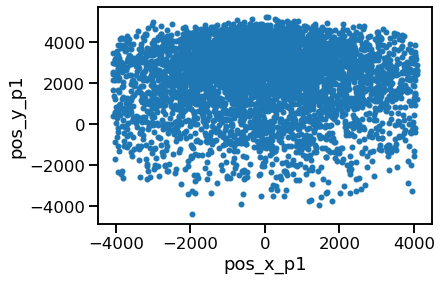

In [247]:
shots_df.plot(x='pos_x_p1', y='pos_y_p1', kind='scatter')

In [248]:
import os
replays = []
for root, dirs, files in os.walk(r"C:\Users\blake\Documents\rlcsseason9"):
    for file in files:
        if file.endswith(".replay"):
            replays.append(os.path.join(root, file))

In [17]:
replays

['C:\\Users\\blake\\Documents\\rlcsseason9\\RLCS Season 9\\Rival Series\\Europe\\Week 1\\M1 - Block Block vs Team Vertex\\44C89A1A44A4E626916BD69677565167.replay',
 'C:\\Users\\blake\\Documents\\rlcsseason9\\RLCS Season 9\\Rival Series\\Europe\\Week 1\\M1 - Block Block vs Team Vertex\\5EED1AC949F411EE50A6D4A6CC389985.replay',
 'C:\\Users\\blake\\Documents\\rlcsseason9\\RLCS Season 9\\Rival Series\\Europe\\Week 1\\M1 - Block Block vs Team Vertex\\CBB0AD6C48F74064E5059BA05D0A3595.replay',
 'C:\\Users\\blake\\Documents\\rlcsseason9\\RLCS Season 9\\Rival Series\\Europe\\Week 1\\M1 - Block Block vs Team Vertex\\D7A4B2664B0C08FF3DE79C986DA45FCD.replay',
 'C:\\Users\\blake\\Documents\\rlcsseason9\\RLCS Season 9\\Rival Series\\Europe\\Week 1\\M2 - Triple Trouble vs RCD Espanyol_\\5798653948E38DAECDF4E698EA99B36A.replay',
 'C:\\Users\\blake\\Documents\\rlcsseason9\\RLCS Season 9\\Rival Series\\Europe\\Week 1\\M2 - Triple Trouble vs RCD Espanyol_\\AF582C344AA5E1A6F1C2B6AF52D9E68D.replay',
 'C:\\

In [18]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [19]:
boost_locs = pd.DataFrame([[-3072.0, -4096.0, 73.0, 'big'],
                           [ 3072.0, -4096.0, 73.0, 'big'],
                           [-3584.0,     0.0, 73.0, 'big'],
                           [ 3584.0,     0.0, 73.0, 'big'],
                           [-3072.0,  4096.0, 73.0, 'big'],
                           [ 3072.0,  4096.0, 73.0, 'big'],
                           [    0.0, -4240.0, 70.0, 'small'],
                           [-1792.0, -4184.0, 70.0, 'small'],
                           [ 1792.0, -4184.0, 70.0, 'small'],
                           [- 940.0, -3308.0, 70.0, 'small'],
                           [  940.0, -3308.0, 70.0, 'small'],
                           [    0.0, -2816.0, 70.0, 'small'],
                           [-3584.0, -2484.0, 70.0, 'small'],
                           [ 3584.0, -2484.0, 70.0, 'small'],
                           [-1788.0, -2300.0, 70.0, 'small'],
                           [ 1788.0, -2300.0, 70.0, 'small'],
                           [-2048.0, -1036.0, 70.0, 'small'],
                           [    0.0, -1024.0, 70.0, 'small'],
                           [ 2048.0, -1036.0, 70.0, 'small'],
                           [-1024.0,     0.0, 70.0, 'small'],
                           [ 1024.0,     0.0, 70.0, 'small'],
                           [-2048.0,  1036.0, 70.0, 'small'],
                           [    0.0,  1024.0, 70.0, 'small'],
                           [ 2048.0,  1036.0, 70.0, 'small'],
                           [-1788.0,  2300.0, 70.0, 'small'],
                           [ 1788.0,  2300.0, 70.0, 'small'],
                           [-3584.0,  2484.0, 70.0, 'small'],
                           [ 3584.0,  2484.0, 70.0, 'small'],
                           [    0.0,  2816.0, 70.0, 'small'],
                           [- 940.0,  3310.0, 70.0, 'small'],
                           [  940.0,  3308.0, 70.0, 'small'],
                           [-1792.0,  4184.0, 70.0, 'small'],
                           [ 1792.0,  4184.0, 70.0, 'small'],
                           [    0.0,  4240.0, 70.0, 'small']], 
                          columns=['boost_pad_x', 'boost_pad_y', 
                                   'boost_pad_z', 'boost_pad_type'])

In [292]:
def show_play(fig, expected_goal, frame, is_goal):
    is_goal = 'Goal' if is_goal == 1 else "No Goal"
    fig = go.Figure(
    data=[
         go.Scatter(x=[-4096,-4096+1152], y=[5120-1152, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
        go.Scatter(x=[-4096,-4096+1152], y=[5120-1152, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
         go.Scatter(x=[4096,4096-1152], y=[5120-1152, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[-4096,-4096+1152], y=[-5120+1152, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
         go.Scatter(x=[-4096,-4096+1152], y=[5120-1152, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
         go.Scatter(x=[4096,4096-1152], y=[-5120+1152, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          
          go.Scatter(x=[-4096,-4096], y=[5120-1152, -5120+1152],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[4096,4096], y=[5120-1152, -5120+1152],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          
          go.Scatter(x=[-4096+1152,-893], y=[5120, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[4096-1152,893], y=[5120, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[-893,893], y=[5120, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          
          go.Scatter(x=[-4096+1152,-893], y=[-5120, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[4096-1152,893], y=[-5120, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[-893,893], y=[-5120, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          
          go.Scatter(x=[-893,893], y=[5120+880, 5120+880],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[893,893], y=[5120+880, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[-893,-893], y=[5120+880, 5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          
          go.Scatter(x=[-893,893], y=[-5120-880, -5120-880],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[893,893], y=[-5120-880, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=[-893,-893], y=[-5120-880, -5120],
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=boost_locs['boost_pad_x'],y=boost_locs['boost_pad_y'], mode='markers', marker=dict(color='pink'))
         
         ],
    layout=go.Layout(
        xaxis=dict(range=[-5000, 5000], autorange=False, zeroline=False),
        yaxis=dict(range=[-6050, 6050], autorange=False, zeroline=False),
        title_text="Expected Goal: {}\n Result: {}".format(expected_goal, is_goal), hovermode="closest",
        width=700,
        height=800
        
        ),
    
    frames=[go.Frame(
        
        data=[go.Scatter(
            x=flat_df.loc[(flat_df.frames == k),'pos_x'].values,
            y=flat_df.loc[(flat_df.frames == k),'pos_y'].values,
            mode="markers",
            
            marker=dict(color=['orange' if game_info.loc[game_info.name == nm].is_orange.values[0] else 'blue' for nm in flat_df.name.unique()], 
                        size=10
                       )),
              go.Scatter(
            x=[df_ball.loc[df_ball.frames == k,'pos_x'].values[0]],
            y=[df_ball.loc[df_ball.frames == k,'pos_y'].values[0]],
            mode="markers",
            marker=dict(color='black', size=10)
                
              )
             ]
            )

        for k in df.loc[df.frames.between(frame-100,frame+150), 'frames'].values]
    )
    fig.update_layout(
    autosize=False,
    width=700,
    height=800,
    updatemenus=[dict(buttons = [dict(
                                               args = [None, {"frame": {"duration": 30, 
                                                                        "redraw": False},
                                                              "fromcurrent": True, 
                                                              "transition": {"duration": 0}}],
                                               label = "Play",
                                               method = "animate")],
                                type='buttons',
                                showactive=False,
                                y=1,
                                x=1.12,
                                xanchor='right',
                                yanchor='top')]
    )
    return fig

In [205]:
def get_players(game):
    df_players = pd.DataFrame()
    for x in game.players:
        df_players = (df_players.append(pd.DataFrame([x.online_id,x.name,x.is_orange]
                                                    ).T,ignore_index=True))
    df_players.columns = ['id','name','is_orange']
        
    return df_players

def get_flat_df(players, df):
    flat_df = pd.DataFrame()
    for x in players:
        frames = df['frames'].unique()
        temp = df[x]
        temp['frames'] = frames
        temp['name'] = x
        flat_df = flat_df.append(temp)
    return flat_df

def get_replay_df(replay_file):
    _json = carball.decompile_replay(replay_file)
    game = Game()
    game.initialize(loaded_json=_json)

    analysis_manager = AnalysisManager(game)
    analysis_manager.create_analysis()
    t = analysis_manager.get_json_data()
    df = analysis_manager.get_data_frame()
    df = df.reset_index().rename(columns={'index':'frames'})
    df_ball = df['ball']
    df_ball['frames'] = df['frames'].values
    players = [x.name for x in game.players]
    flat_df = get_flat_df(players, df)
    print(game.name)
    game_info = pd.DataFrame([[format(game.datetime,"%Y%m%d%H%M%S"),game.game_info.match_guid,game.name[4],game.id]],columns=['match_date','match_id','game_number','game_id'])
    player_info = get_players(game)
    players = [x.name for x in game.players]
    game_info = pd.concat((game_info,player_info),axis=1)
    game_info = game_info.fillna(method='ffill')
    return df, flat_df, game_info, players, df_ball

In [206]:
df, flat_df, game_info, players, df_ball = get_replay_df(shots_df.replay_name.values[0])

Player RLCS Admin as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Admin as player has no team.
Player RLCS Observer 1 as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer 1 as player has no team.
Player RLCS Observer 3 as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer 3 as player has no team.
Player RLCS Observer 2 as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer 2 as player has no team.
Dropping these columns[('game', 'is_overtime')]
The player never hit the ball during the "carry"
The player never hit the ball during the "carry"
C:\Users\blake\AppData\Roaming\Python\Python38\site-packages\numpy\lib\format.py:431: UserWarning:

Stored array in format 3.0. It can only be read by NumPy >= 1.17

<ipython-input-205-13e91061d822>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

m1 g3 bb vs vert


In [202]:
game_info

,match_date,match_id,game_number,game_id,id,name,is_orange
0,20200214104013,63BEE7A811EA4F58155129BBDFFAEFCB,3.0,44C89A1A44A4E626916BD69677565167,76561198246237074,doomayn 幸せ,True
1,20200214104013,63BEE7A811EA4F58155129BBDFFAEFCB,3.0,44C89A1A44A4E626916BD69677565167,76561198150969845,Kerian,False
2,20200214104013,63BEE7A811EA4F58155129BBDFFAEFCB,3.0,44C89A1A44A4E626916BD69677565167,76561198258466111,ExoTiiK,False
3,20200214104013,63BEE7A811EA4F58155129BBDFFAEFCB,3.0,44C89A1A44A4E626916BD69677565167,76561198303347154,Meloshisu,False
4,20200214104013,63BEE7A811EA4F58155129BBDFFAEFCB,3.0,44C89A1A44A4E626916BD69677565167,76561198008942341,Gnagflow06,True
5,20200214104013,63BEE7A811EA4F58155129BBDFFAEFCB,3.0,44C89A1A44A4E626916BD69677565167,76561198079884662,coKaaa,True


In [271]:
shots_df[['frames', 'replay_name']]

,frames,replay_name
0,173,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
1,529,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
2,1152,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
3,1489,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
4,4542,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
...,...,...
6178,5806,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
6179,6548,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
6180,7138,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...
6181,7243,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...


In [249]:
X_cols = shots_df.columns[:78].tolist() + shots_df.columns[80:91].tolist()
pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

In [284]:
X = shots_df[shots_df.columns[:78].tolist() + shots_df.columns[80:91].tolist()].values
y = shots_df['is_goal'].values
X = pipeline.fit_transform(X)
train_indices = shots_df.index[:4000]
test_indices = shots_df.index[4000:]

In [285]:
X_train, X_test, y_train, y_test = X[:4000], X[4000:], y[:4000], y[4000:]

In [286]:
#using weight since i have such an imbalanced dataset (a lot more missed shots than goals)
w = {0:1, 1:99}

In [253]:
clf = LogisticRegression(random_state=0, class_weight=w).fit(X_train, y_train)

In [295]:
shots_df.is_goal.value_counts()

0.0    3990
1.0    1057
Name: is_goal, dtype: int64

In [254]:
clf.predict(X_test[:5, :])

array([1., 1., 0., 1., 0.])

In [255]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_train, cv=4, scoring='accuracy')

array([0.54666667, 0.56      , 0.57333333, 0.52266667])

In [256]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [257]:
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)

C:\Users\blake\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\blake\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [258]:
confusion_matrix(y_train, y_train_pred)

array([[543, 633],
       [ 25, 299]], dtype=int64)

In [259]:
y_pred = clf.predict(X_test)

In [260]:
clf.score(X_test, y_test)

0.4905553989286721

In [261]:
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [262]:
from sklearn.model_selection import GridSearchCV

lg = LogisticRegression(random_state=0)
grid = GridSearchCV(lg,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.8269050699300701 with param: {'class_weight': {0: 1.0, 1: 1.0}}


In [274]:
#turns out best weight is evenly distributed
w = {0: 1, 1: 1}

In [275]:
clf = LogisticRegression(random_state=0, class_weight=w).fit(X_train, y_train)

In [276]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_train, cv=4, scoring='accuracy')

array([0.822, 0.813, 0.814, 0.809])

In [277]:
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)

In [278]:
confusion_matrix(y_train, y_train_pred)

array([[2951,  210],
       [ 542,  297]], dtype=int64)

In [279]:
clf.score(X_test, y_test)

0.8194842406876791

In [287]:
goal_probs = clf.predict_proba(X_test)[:, 1]

In [288]:
results_df = shots_df.loc[test_indices]

In [289]:
results_df['expected_goal'] = goal_probs

In [290]:
results_df

,pos_x_p1,pos_y_p1,pos_z_p1,vel_x_p1,vel_y_p1,vel_z_p1,ang_vel_x_p1,ang_vel_y_p1,ang_vel_z_p1,rot_x_p1,...,ang_vel_y,ang_vel_z,rot_x,rot_y,rot_z,is_goal,id,replay_name,date,expected_goal
4921,2373.709961,3301.760010,996.080017,-12541.899414,15733.000488,-1220.000000,-2320.099945,264.099998,-1738.099976,-0.901524,...,898.399963,3361.499939,0.036974,0.882725,-1.983552,0.0,916019FC11EA6B0F87EF53BC777CAF14,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-20 21:08:46,0.135249
4922,-3369.100098,2239.370117,1002.840027,14710.600586,14377.500000,311.399994,5318.099976,-1402.299957,-26.099999,-0.502260,...,-298.600006,-4079.100037,-0.759213,0.452975,2.363330,0.0,746D9D8411EA6B0EB55153BC5FFA8FCB,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-20 21:01:13,0.044166
4925,3594.750000,1792.020020,379.140015,-5600.200195,21158.601074,3460.899963,-662.200012,-2512.799988,-4646.000061,-0.496193,...,871.100006,5934.299927,0.372164,1.117096,-0.334480,0.0,746D9D8411EA6B0EB55153BC5FFA8FCB,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-20 21:01:13,0.123071
4926,-3355.500000,1566.339966,259.600006,9139.699707,19118.000488,2668.699951,-912.399979,5232.100220,-1428.999939,-0.182415,...,-2112.599945,-5009.500122,0.564321,2.161200,-0.186814,0.0,746D9D8411EA6B0EB55153BC5FFA8FCB,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-20 21:01:13,0.096685
4927,-3936.739990,3359.290039,1292.910034,9358.300171,4665.899963,13922.299805,580.999985,1801.399994,5164.000244,-0.846644,...,4121.000061,-2721.199951,0.458351,-2.180656,-2.568234,0.0,746D9D8411EA6B0EB55153BC5FFA8FCB,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-20 21:01:13,0.166151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,634.039978,3449.469971,67.000000,793.600006,10532.700195,3454.800110,545.900002,-2414.199982,2986.700134,-0.031435,...,3921.900024,2695.000000,0.279520,0.248359,2.198718,0.0,374E0F7C11EA71F5396D53A768244BC6,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-29 12:48:09,0.068134
6179,1025.660034,3315.929932,956.760010,-7700.300293,13933.499756,-8309.699707,4428.699951,-1878.000031,2666.199951,0.175196,...,3799.400024,2993.699951,-0.084366,0.934809,-2.336562,0.0,374E0F7C11EA71F5396D53A768244BC6,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-29 12:48:09,0.146230
6180,1332.780029,4347.270020,620.739990,-4256.499939,14983.800049,-349.900017,-4007.699890,-2755.700073,1819.299927,1.306275,...,-411.100006,5402.899780,-0.015008,-2.249324,2.693790,0.0,374E0F7C11EA71F5396D53A768244BC6,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-29 12:48:09,0.289339
6181,-447.929993,1621.849976,465.170013,12594.799805,12785.600586,3888.200073,-2056.300049,-749.199982,2126.199951,-0.634573,...,-5217.800293,2243.000031,-0.339831,2.045483,0.485877,0.0,374E0F7C11EA71F5396D53A768244BC6,C:\Users\blake\Documents\rlcsseason9\RLCS Seas...,2020-03-29 12:48:09,0.083674


Player RLCS Admin as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Admin as player has no team.
Player Achieves as player has no MatchScore.
Score is not found for player
Ignoring player: Achieves as player has no team.
Player WavePunk as player has no MatchScore.
Score is not found for player
Ignoring player: WavePunk as player has no team.
Player RLCS Observer as player has no MatchScore.
Score is not found for player
Ignoring player: RLCS Observer as player has no team.
Dropping these columns[('game', 'is_overtime')]
<ipython-input-205-13e91061d822>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-205-13e91061d822>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice fro

m1 g1 rec vs mouz


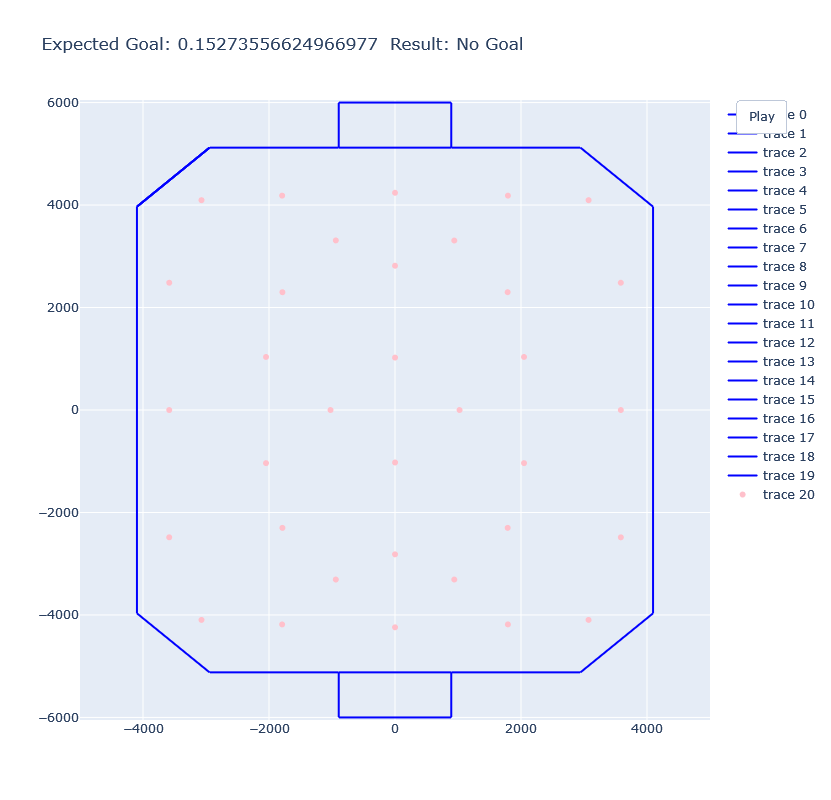

In [294]:
random_sample = results_df.sample(1)
replay = random_sample['replay_name'].values[0]
df, flat_df, game_info, players, df_ball = get_replay_df(replay)
is_goal = random_sample['is_goal'].values[0]
fig = show_play(go.Figure(), random_sample['expected_goal'].values[0], random_sample['frames'].values[0], is_goal)
fig.show()